In [963]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import numpy as np

symbol = 'amd'
start_date = '2000-01-01'
end_date = '2020-01-01'

start_date_obj = datetime.strptime(start_date, "%Y-%m-%d")
end_date_ojb = datetime.strptime(end_date, "%Y-%m-%d")

def download_data(symbol):
    price_raw = yf.download(symbol, start=start_date, end=end_date)
    price_raw.to_csv(symbol + '.csv')
    ticker = yf.Ticker(symbol)
    ticker.get_earnings_dates(limit=100).to_csv(symbol + '_earnings_dates')
    
download_data(symbol)

[*********************100%***********************]  1 of 1 completed


In [977]:
prices = pd.read_csv(symbol + '.csv').iloc[2:,:].rename(columns={'Price': 'Date'})
prices['Date'] = pd.to_datetime(prices['Date'])
prices = prices.set_index('Date')
prices = prices.astype(float)
prices['Percent Change'] = prices['Close'].pct_change()
prices

,Close,High,Low,Open,Volume,Percent Change
Date,,,,,,
2000-01-03,15.500000,15.593750,14.687500,14.968750,7843200.0,NaN
2000-01-04,14.625000,15.500000,14.593750,15.125000,6290200.0,-0.056452
2000-01-05,15.000000,15.062500,14.000000,14.531250,8204600.0,0.025641
2000-01-06,16.000000,16.000000,15.250000,15.500000,11489400.0,0.066667
2000-01-07,16.250000,16.406250,15.375000,15.406250,8543400.0,0.015625
...,...,...,...,...,...,...
2019-12-24,46.540001,46.610001,45.770000,46.099998,44432200.0,0.023757
2019-12-26,46.630001,47.310001,45.660000,46.990002,57562800.0,0.001934
2019-12-27,46.180000,46.880001,45.980000,46.849998,36581300.0,-0.009650


In [1050]:
threshold = 0.06

def get_metrics(threshold=threshold, back=60):
    column_names = []
    columns = []
    for d in range(3, back):
        columns.append((prices['Percent Change'] > threshold).rolling(window=d, closed='left').sum())
        column_names.append('Positive Count' + str(d))
        columns.append(prices['Percent Change'].rolling(window=d, closed='left').std() * np.sqrt(252))
        column_names.append('Volatility' + str(d))
        columns.append(prices['Volume'].shift(1) / prices['Volume'].rolling(window=d, closed='left').mean())
        column_names.append('Rvol' + str(d))
        
        hi = prices['High'].rolling(window=d, closed='left').max()
        lo = prices['Low'].rolling(window=d, closed='left').min()
        columns.append((prices['Close'].shift(1) - lo) / (hi - lo))
        column_names.append('Price Position' + str(d))
    
    data = pd.concat(columns, join='outer', axis=1)
    data.columns = column_names

    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=5)
    data['next_prices'] = prices['High'].shift(-1).rolling(window=indexer).max()
    data['MONEY'] = (data['next_prices'] > prices['Close'].shift(1) * (1 + threshold)).astype(int)
    data = data.dropna().drop('next_prices', axis=1)
    return data

stock_data = get_metrics(threshold=threshold)
stock_data['MONEY'].value_counts()


MONEY
0    2785
1    2181
Name: count, dtype: int64


Fold 1
Train: 2017-10-02 to 2017-12-26
Test: 2017-12-27

Fold 2
Train: 2017-10-09 to 2018-01-03
Test: 2018-01-04

Fold 3
Train: 2017-10-16 to 2018-01-10
Test: 2018-01-11

Fold 4
Train: 2017-10-23 to 2018-01-18
Test: 2018-01-19

Fold 5
Train: 2017-10-30 to 2018-01-25
Test: 2018-01-26

Fold 6
Train: 2017-11-06 to 2018-02-01
Test: 2018-02-02

Fold 7
Train: 2017-11-13 to 2018-02-08
Test: 2018-02-09

Fold 8
Train: 2017-11-20 to 2018-02-15
Test: 2018-02-16

Fold 9
Train: 2017-11-28 to 2018-02-23
Test: 2018-02-26

Fold 10
Train: 2017-12-05 to 2018-03-02
Test: 2018-03-05

Fold 11
Train: 2017-12-12 to 2018-03-09
Test: 2018-03-12

Fold 12
Train: 2017-12-19 to 2018-03-16
Test: 2018-03-19

Fold 13
Train: 2017-12-27 to 2018-03-23
Test: 2018-03-26

Fold 14
Train: 2018-01-04 to 2018-04-02
Test: 2018-04-03

Fold 15
Train: 2018-01-11 to 2018-04-09
Test: 2018-04-10

Fold 16
Train: 2018-01-19 to 2018-04-16
Test: 2018-04-17

Fold 17
Train: 2018-01-26 to 2018-04-23
Test: 2018-04-24

Fold 18
Train: 2018-02

<Axes: >

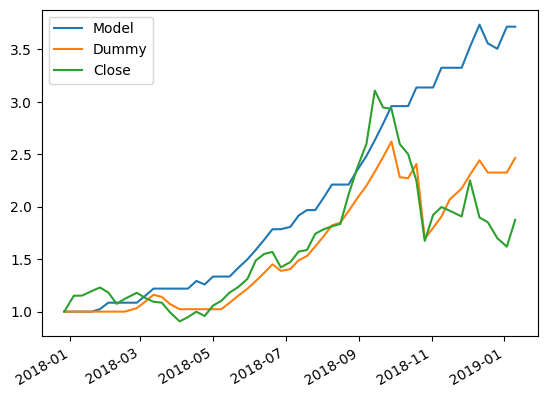

In [1056]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt


def money_update(money, predictions, truth, start, holding_period=5, threshold=threshold):
    if predictions[0] == truth:
        if predictions[0] == 1:
            money *= 1 + (predictions[0] * threshold)
    else:
        if predictions[0] == 1:
            start = prices.index.get_loc(stock_data.index[start])
            money *= prices['Close'].iloc[start+holding_period] / prices['Close'].iloc[start+1]
    return money

def backtest(model, start, folds=52, train_size=60):
    '''
    Simulates model on past stock data to analyze performance compared to dummy
    :param model: sklearn model
    :param start: datetime object 
    :param folds: how many weeks to simulate
    :param train_size: how many days prior to train model on
    :return: performance metrics of models
    '''
    dummy = DummyClassifier(strategy='most_frequent')
    performance = pd.DataFrame({'prev': [1, 1, np.nan]}, index=['Model', 'Dummy', 'Accuracy'])
    train_id = stock_data.index.get_loc(start)
    test_id = train_id + train_size
    for f in range(folds):
        test_date = stock_data.index[test_id].date()
        X_train, X_test = X[train_id:test_id], X[test_id]
        y_train, y_test = y[train_id:test_id], y[test_id]
        
        print(f'\nFold {f + 1}')
        print(f"Train: {stock_data.index[train_id].date()} to {stock_data.index[test_id - 1].date()}")
        print(f"Test: {test_date}")
        
        model.fit(X_train, y_train)
        dummy.fit(X_train, y_train)
        y_hat = model.predict(X_test.reshape(1, -1))
        y_fat = dummy.predict(X_test.reshape(1, -1))
        
        prev = performance['prev']
        performance = performance.rename({'prev': test_date}, axis=1)
        model_money = money_update(prev['Model'], y_hat, y_test, test_id)
        dummy_money = money_update(prev['Dummy'], y_fat, y_test, test_id)
        performance['prev'] = [model_money, dummy_money, (y_hat == y_test)[0]]

        train_id += 5
        test_id += 5
    final_test_date = pd.Timestamp(performance.columns[-2])
    performance = performance.rename({'prev': prices.index[prices.index.get_loc(final_test_date) + 5]}, axis=1)
    performance.columns = pd.to_datetime(performance.columns)
    return performance.T
    
X = stock_data.iloc[:,:-1].values
y = stock_data['MONEY'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
results = backtest(model, datetime(2017, 10, 2))
results['Close'] = prices['Close']
results['Close'] = results['Close'] / results['Close'].iloc[0]
results.plot()


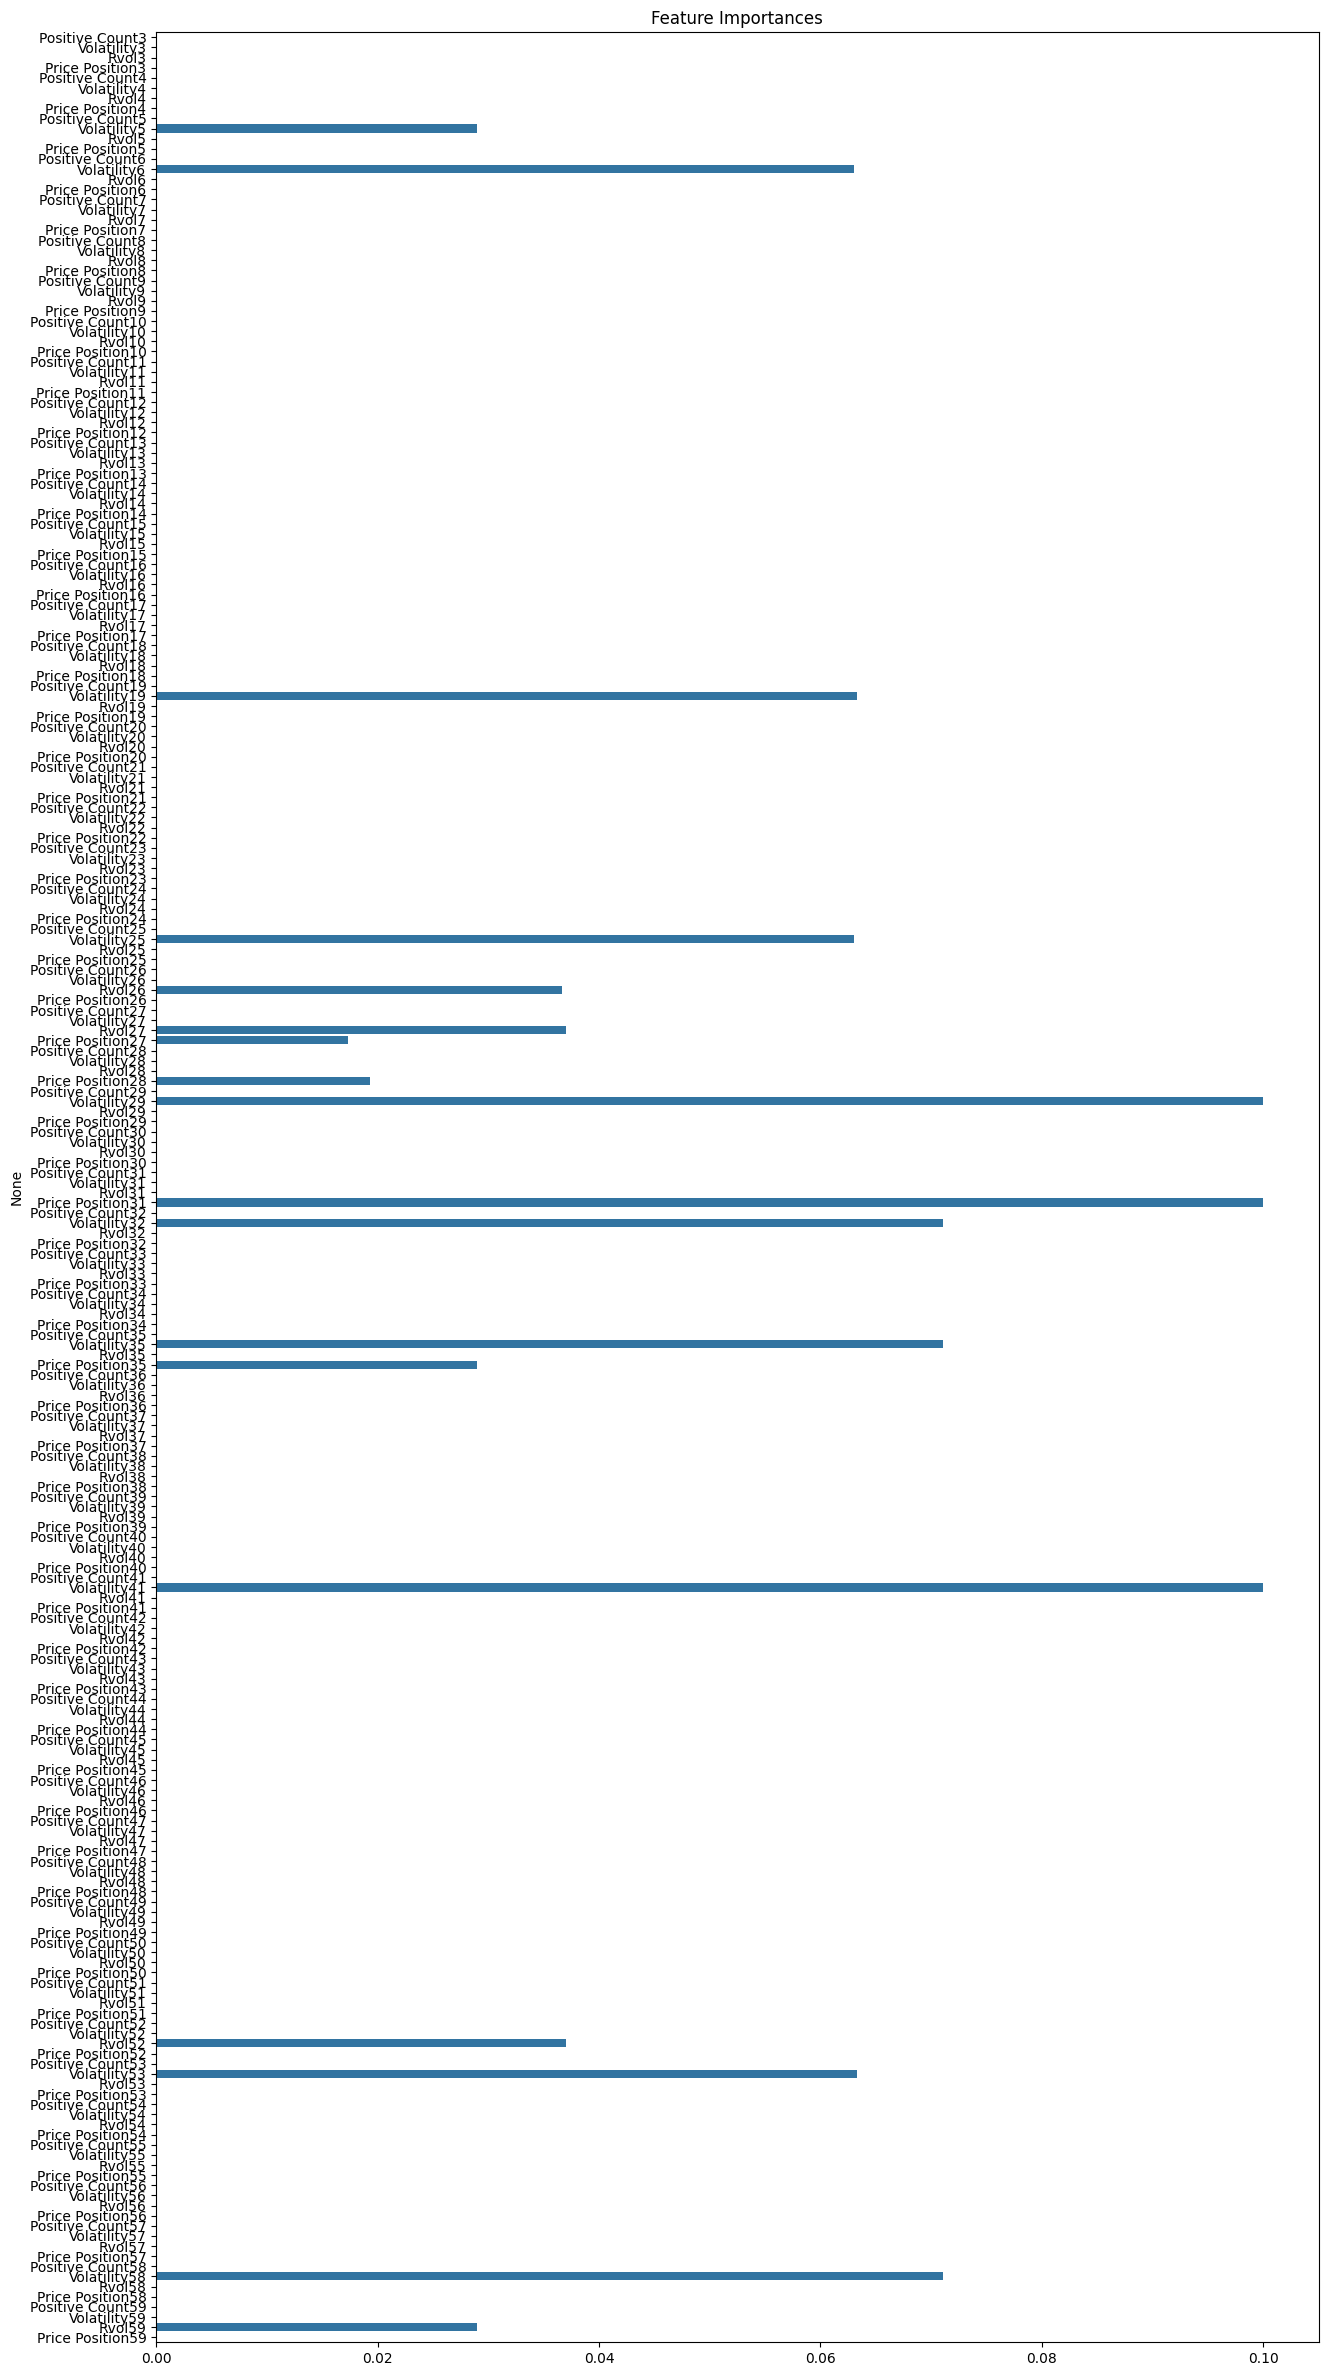

In [987]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = model.feature_importances_
features = stock_data.drop('MONEY', axis=1).columns

plt.figure(figsize=(15, 30))
sns.barplot(x=feature_importances, y=features)
plt.title("Feature Importances")
plt.yticks(fontsize=10)
plt.tight_layout
plt.show()

In [435]:
import torch
from torch.utils.data import TensorDataset, DataLoader

x_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()
train_ds = TensorDataset(x_tensor, y_tensor)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

In [436]:

import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # Use Softmax if doing multi-class
        )

    def forward(self, x):
        return self.model(x)


In [437]:
model = MLP()
criterion = nn.BCELoss()  # Use BCEWithLogitsLoss() if removing Sigmoid from model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(pd.Series(y_train).value_counts(normalize=True))

# Training loop
for epoch in range(20):
    model.train()
    for xb, yb in train_dl:
        preds = model(xb).squeeze()
        loss = criterion(preds, yb.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}: loss = {loss.item():.4f}")


0    0.530645
1    0.469355
Name: proportion, dtype: float64
Epoch 1: loss = 0.6554
Epoch 2: loss = 0.7094
Epoch 3: loss = 0.7034
Epoch 4: loss = 0.7177
Epoch 5: loss = 0.7353
Epoch 6: loss = 0.7569
Epoch 7: loss = 0.7179
Epoch 8: loss = 0.5963
Epoch 9: loss = 0.7554
Epoch 10: loss = 0.6462
Epoch 11: loss = 0.6574
Epoch 12: loss = 0.6776
Epoch 13: loss = 0.7183
Epoch 14: loss = 0.6856
Epoch 15: loss = 0.6932
Epoch 16: loss = 0.6537
Epoch 17: loss = 0.7462
Epoch 18: loss = 0.7012
Epoch 19: loss = 0.6506
Epoch 20: loss = 0.7709
